In [1]:
import os
import tarfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import radical.analytics as ra

plt.style.use(ra.get_mplstyle('radical_mpl'))

In [2]:
! radical-stack


  python               : /root/miniconda3/bin/python3
  pythonpath           : 
  version              : 3.7.6
  virtualenv           : base

  radical.analytics    : 1.6.7
  radical.entk         : 1.9.0
  radical.gtod         : 1.5.0
  radical.pilot        : 1.10.0
  radical.saga         : 1.8.0
  radical.utils        : 1.9.0



In [3]:
metrics = [
    ['Bootstrap', ['boot', 'setup_1']                         , '#c6dbef'],
    ['Warmup'   , ['warm' ]                                   , '#f0f0f0'],
    ['Schedule' , ['exec_queue','exec_prep', 'unschedule']    , '#c994c7'],
    ['Exec RP'  , ['exec_rp', 'exec_sh', 'term_sh', 'term_rp'], '#fdbb84'],
    ['Exec Cmd' , ['exec_cmd']                                , '#e31a1c'],
    ['Cooldown' , ['drain']                                   , '#addd8e']
]

In [4]:
#sids = ['re.session.login5.litan.018955.0004',
#        're.session.login5.litan.018956.0001',
#        're.session.login3.litan.018956.0002']
sids = ['re.session.login1.litan.018960.0000',
        're.session.login3.litan.018959.0000',
        're.session.login1.litan.018944.0008']
sdir = '../sessions/'
sessions = [sdir+s for s in sids]

for sid in sids:
    sp = sdir+sid+'.tar.bz2'
    tar = tarfile.open(sp, mode='r:bz2')
    tar.extractall(path=sdir)
    tar.close()

ss = {}
for sid in sids:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot', inplace=False),
                    't': ss[sid]['s'].filter(etype='task' , inplace=False)})

for sid in sids:
    ss[sid].update({'cores_node': ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
                    'pid'       : ss[sid]['p'].list('uid'),
                    'ntask'     : len(ss[sid]['t'].get())
    })

    ss[sid].update({'ncores'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'     : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']
    })

    ss[sid].update({'nnodes'    : int(ss[sid]['ncores']/ss[sid]['cores_node'])})

Text(0.5, -0.3, 'Time (s)')

findfont: Font family ['[serif]'] not found. Falling back to DejaVu Sans.


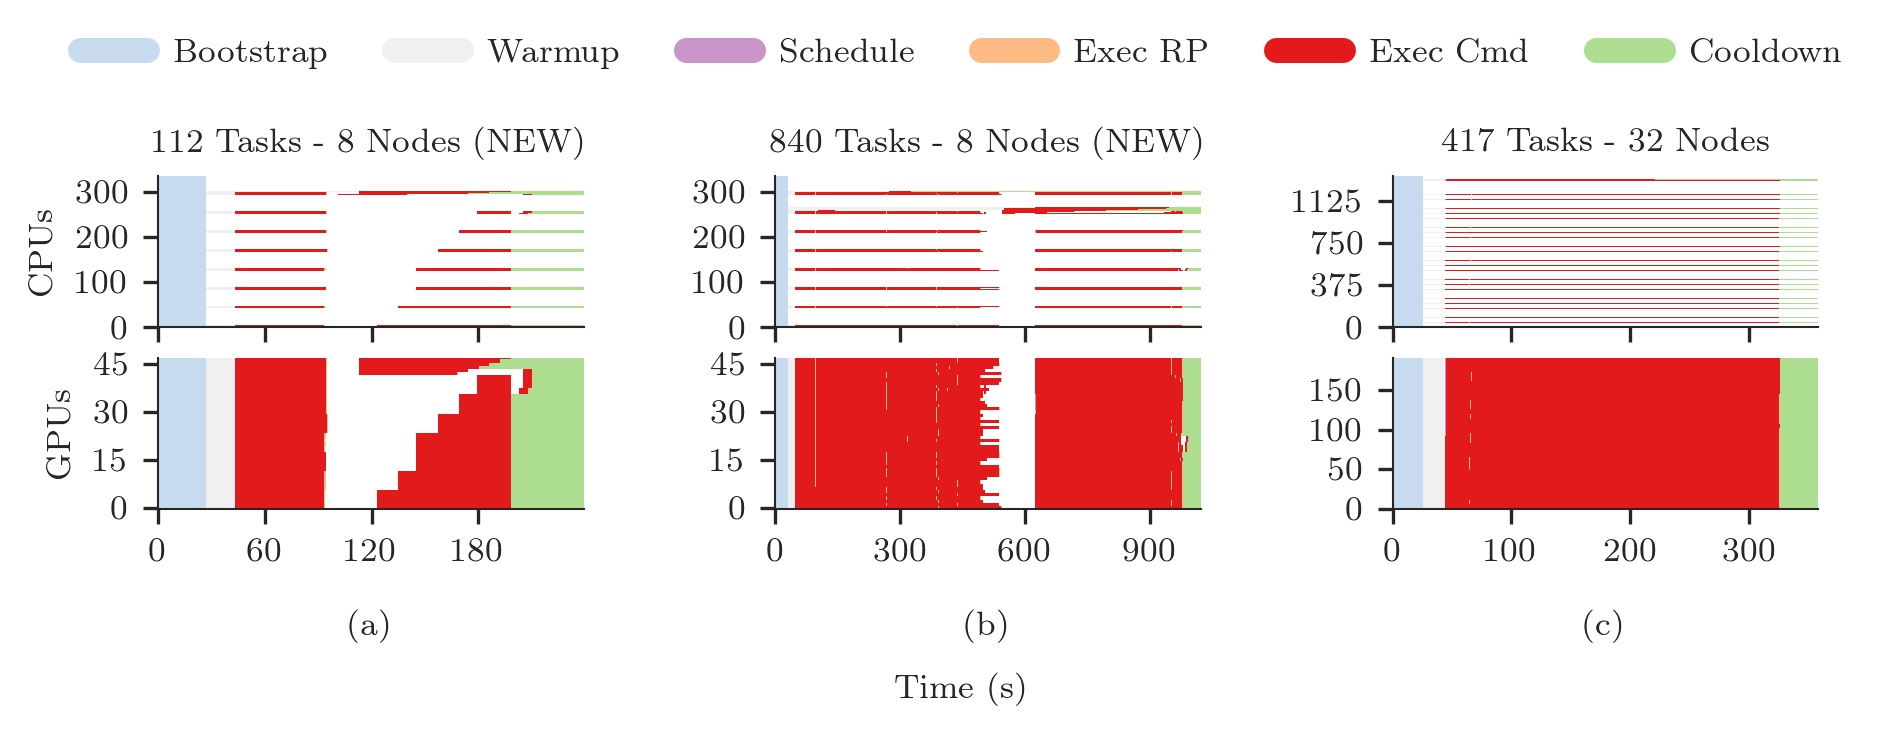

In [5]:
exp = ra.Experiment(sessions, stype='radical.pilot')
p_zeros = ra.get_pilots_zeros(exp)

# Type of resource we want to plot: cpu or gpu
rtypes=['cpu', 'gpu']

provided, consumed, stats_abs, stats_rel, info = exp.utilization(metrics=metrics, rtype=rtypes[1])

# sessions you want to plot
splot = [os.path.basename(s) for s in sessions]
nsids = len(splot)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(2, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels

legend = None
for k, rtype in enumerate(rtypes):
    _, consumed, _, _, _ = exp.utilization(metrics=metrics, rtype=rtype)
    j = 'a'
    for i, sid in enumerate(splot):

        # we know we have only 1 pilot
        pid = ss[sid]['p'].list('uid')[0]

        # Plot legend, patched, X and Y axes objects
        legend, patches, x, y = ra.get_plot_utilization(metrics, consumed, p_zeros[sid][pid], sid)

        # Place all the patches, one for each metric, on the axes
        for patch in patches:
            axarr[k][i].add_patch(patch)

        # Title of the plot. Facultative, requires info about session (see RA
        # Info Chapter). We set the title only on the first raw of plots
        if rtype == 'cpu':
            if sid == 're.session.login1.litan.018960.0000' or sid == 're.session.login3.litan.018959.0000':
                axarr[k][i].set_title('%s Tasks - %s Nodes (NEW)' % (ss[sid]['ntask'],
                        int(ss[sid]['nnodes'])))
            else:
                axarr[k][i].set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'],
                        int(ss[sid]['nnodes'])))

        # Format axes
        axarr[k][i].set_xlim([x['min'],     x['max']])
        axarr[k][i].set_ylim([y['min'], int(y['max'])])
        axarr[k][i].yaxis.set_major_locator(mticker.MaxNLocator(4))
        axarr[k][i].xaxis.set_major_locator(mticker.MaxNLocator(4))
        
        if rtype == 'cpu':
            # Specific to Summit when using SMT=4 (default)
            axarr[k][i].yaxis.set_major_formatter(
                    mticker.FuncFormatter(lambda z, pos: int(z/4)))

        # Y label per subplot. We keep only the 1st for each raw.
        if i == 0:
            axarr[k][i].set_ylabel('%ss' % rtype.upper())

        # Set x labels to letters for references in the paper.
        # Set them only for the bottom-most subplot
        if rtype == 'gpu':
            axarr[k][i].set_xlabel('(%s)' % j, labelpad=10)

        # update session id and raw identifier letter
        j = chr(ord(j) + 1)

# Add legend
fig.legend(legend, [m[0] for m in metrics],
           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6)

# Add axes labels
fig.text(0.5, -0.3, 'Time (s)', ha='center')